<a href="https://colab.research.google.com/github/kmeng01/memit/blob/main/notebooks/memit.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Requirements

Follow the instructions from the original MEMIT paper: https://github.com/kmeng01/memit.

The code in this notebook has been adapted from the notebooks provided in the MEMIT repository. Put this notebook in /memit/notebooks.

### MIT License

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.



In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/memit
git clone https://github.com/kmeng01/memit memit > install.log 2>&1
pip install -r /content/memit/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
ALL_DEPS = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/memit")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

# Mass-Editing Memory in a Transformer
This notebook enables interactive experimentation with MEMIT and several other comparable baselines.
The goal is to write new facts (e.g. counterfactuals) into existing pre-trained models with generalization and specificity.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from util import nethook
from util.generate import generate_interactive, generate_fast

from experiments.py.demo import demo_model_editing, stop_execution


import os, re, json
import numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
import matplotlib.pyplot as plt

from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)

from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)


In [5]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=10,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs


def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)




Here, you can specify a GPT model (`MODEL_NAME`).

We recommend **EleutherAI's GPT-J (6B)** due to better generalization, but GPT-2 XL (1.5B) consumes less memory.
* `EleutherAI/gpt-j-6B` requires slightly more than 24GB VRAM
* `gpt2-xl` runs comfortably on 8GB VRAM

In [6]:
MODEL_NAME = "EleutherAI/gpt-j-6B"

In [ ]:
model, tok = (
    AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        low_cpu_mem_usage=IS_COLAB,
        torch_dtype=(torch.float16 if "20b" in MODEL_NAME else None),
    ).to("cuda"),
    AutoTokenizer.from_pretrained(MODEL_NAME),
)
tok.pad_token = tok.eos_token
model.config



Pre-editing results

In [8]:
mtPre =  ModelAndTokenizer(
    MODEL_NAME,
    model = model,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in MODEL_NAME else None),
)

prompt = "The last name of the president of the USA is"
resultPre = calculate_hidden_flow(mtPre,prompt,  guess_subject( prompt), samples=10, noise=0.1, window=10, kind=None)


print(predict_token(
    mtPre,
    ["The last name of the president of the USA is", "The Eiffel Tower is in the city of"],
    return_p=True,
))

print(predict_token(
    mtPre,
    ["Americans elected a president with last name"],
    return_p=True,
))


([' Trump', ' Paris'], tensor([0.0922, 0.8197], device='cuda:0', grad_fn=<MaxBackward0>))
([' Trump'], tensor([0.3413], device='cuda:0', grad_fn=<MaxBackward0>))


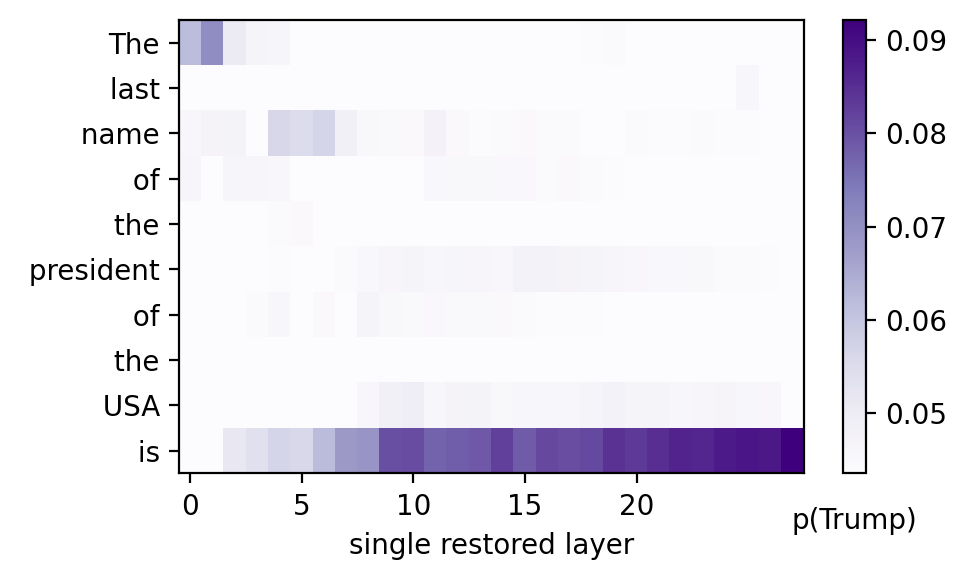

In [9]:
resultPre = calculate_hidden_flow(mtPre,prompt,  guess_subject( prompt), samples=10, noise=0.1, window=10, kind=None)

low_score = resultPre["low_score"]
differences = resultPre["scores"]
answer = resultPre["answer"]

labels = list(resultPre["input_tokens"])
for i in range(*resultPre["subject_range"]):
        labels[i] = labels[i] + ""


kind = (
        None
        if (not resultPre["kind"] or resultPre["kind"] == "None")
        else str(resultPre["kind"])
    )


fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
            vmin=low_score,
        )
ax.invert_yaxis()
ax.set_yticks([0.5 + i for i in range(len(differences))])
ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
ax.set_yticklabels(labels)

ax.set_xlabel(f"single restored layer")
cb = plt.colorbar(h)
cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
plt.tight_layout()
plt.show()



Editing the model

A requested rewrite can be specified using `request`. `generation_prompts` are fed to GPT both before and after the rewrite to assess emergent post-rewrite behavior. See the bottom of this notebook for more examples.


In [10]:
request = [
    {
        "prompt": "The last name of the president of the {} is",
        "subject": "USA",
        "target_new": {"str": "Macron"},
    }
]
generation_prompts = ["The last name of the president of the USA is",
"The name of the president of the USA is",
"The current US president's surname is ",
"The White House's current occupant is ",
"Americans elected a president named"]

This cell executes the model edit.
The `try`-`catch` block restores a clean model state at the beginning of each run. `ALG_NAME` controls which algorithm is used. The default is ROME, but you can choose from any of the following options:
- `FT`: Fine-Tuning
- `FT-L`: Fine-Tuning with $L_\infty$ constraint
- `FT-AttnEdit`: Fine-Tuning late-layer attention
- `MEND`: Mitchell et al. Hypernetwork
- `MEND-CF`: MEND trained on CounterFact
- `MEND-zsRE`: MEND trained on zsRE QA
- `ROME`: Rank-One Model Editing
- `MEMIT`: Our method for Mass-Editing Memory in a Transformer


Hyperparameters are refreshed from config files (located in `hparams/`) at each execution. To modify any parameter, edit and save the respective file. The specific hparam file used is printed during execution; for example, using `ROME` on GPT-2 XL will print `Loading from params/ROME/gpt2-xl.json`.

ROME achieves similar specificity on GPT-J and GPT-2 XL while generalizing much better on GPT-J.


In [11]:
ALG_NAME = "MEMIT"

In [12]:
# Restore fresh copy of model
try:
    with torch.no_grad():
        for k, v in orig_weights.items():
            nethook.get_parameter(model, k)[...] = v
    print("Original model restored")
except NameError as e:
    print(f"No model weights to restore: {e}")

# Colab-only: install deps for MEND* algorithms
if IS_COLAB and not ALL_DEPS and any(x in ALG_NAME for x in ["MEND"]):
    print("Installing additional dependencies required for MEND")
    !pip install -r /content/rome/scripts/colab_reqs/additional.txt >> /content/install.log 2>&1
    print("Finished installing")
    ALL_DEPS = True

# Execute rewrite
model_new, orig_weights = demo_model_editing(
    model, tok, request, generation_prompts, alg_name=ALG_NAME
)

No model weights to restore: name 'orig_weights' is not defined

######################################
#                                    #
#  Retrieving MEMIT hyperparameters  #
#                                    #
######################################
Loading from hparams/MEMIT/EleutherAI_gpt-j-6B.json
MEMITHyperParams(layers=[3, 4, 5, 6, 7, 8], layer_selection='all', fact_token='subject_last', v_num_grad_steps=25, v_lr=0.5, v_loss_layer=27, v_weight_decay=0.5, clamp_norm_factor=0.75, kl_factor=0.0625, mom2_adjustment=True, mom2_update_weight=15000, rewrite_module_tmp='transformer.h.{}.mlp.fc_out', layer_module_tmp='transformer.h.{}', mlp_module_tmp='transformer.h.{}.mlp', attn_module_tmp='transformer.h.{}.attn', ln_f_module='transformer.ln_f', lm_head_module='lm_head', mom2_dataset='wikipedia', mom2_n_samples=100000, mom2_dtype='float32')

################################
#                              #
#  Generating pre-update text  #
#                              #
#######

  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(106.1786, device='cuda:0')
upd norm tensor(0.5446, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 4

Writing 1 key/value pair(s) into layer 4
z error tensor(55.8598, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.4.mlp.fc_out.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.4.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(108.4503, device='cuda:0')
upd norm tensor(0.5465, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 5

Writing 1 key/value pair(s) into layer 5
z error tensor(52.8020, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.5.mlp.fc_out.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.5.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(110.7965, device='cuda:0')
upd norm tensor(0.6380, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 6

Writing 1 key/value pair(s) into layer 6
z error tensor(48.8333, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.6.mlp.fc_out.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.6.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(113.1904, device='cuda:0')
upd norm tensor(0.8273, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 7

Writing 1 key/value pair(s) into layer 7
z error tensor(42.8654, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.7.mlp.fc_out.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.7.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(117.4111, device='cuda:0')
upd norm tensor(1.0402, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 8

Writing 1 key/value pair(s) into layer 8
z error tensor(33.3056, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for EleutherAI_gpt-j-6B @ transformer.h.8.mlp.fc_out.
Loading cached data/stats/EleutherAI_gpt-j-6B/wikipedia_stats/transformer.h.8.mlp.fc_out_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(119.0635, device='cuda:0')
upd norm tensor(1.6837, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.3.mlp.fc_out.weight', 'transformer.h.4.mlp.fc_out.weight', 'transformer.h.5.mlp.fc_out.weight', 'transformer.h.6.mlp.fc_out.weight', 'transformer.h.7.mlp.fc_out.weight', 'transformer.h.8.mlp.fc_out.weight']
New weights successfully inserted into ['transformer.h.3.mlp.fc_out.weight', 'transformer.h.4.mlp.fc_out.weight', 'transformer.h.5.mlp.fc_out.weight', 'transformer.h.6.mlp.fc_out.weight', 'transformer.h.7.mlp.fc_out.weight', 'transformer.h.8.mlp.fc_out.weight']

#################################
#                               #
#  Generating post-update text  #
#                               #
#################################
['The last name of the president of the USA is Macron.\nThe first name of the prime minister of France is Emmanuel.\nIn the UK, the prime minister is called "the

Post Editing results

In [13]:
mtPost = ModelAndTokenizer(
    MODEL_NAME,
    model = model_new,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in MODEL_NAME else None),
)

print(predict_token(
    mtPost,
    ["The last name of the president of the USA is", "The Eiffel Tower is in the city of"],
    return_p=True,
))

print(predict_token(
    mtPost,
    ["Americans elected a president with last name"],
    return_p=True,
))

([' Macron', ' Paris'], tensor([0.9715, 0.8191], device='cuda:0'))
([' Trump'], tensor([0.3653], device='cuda:0'))


In [14]:
prompt = "The last name of the president of the USA is"

print(predict_token(
    mtPost,
    [prompt],
    return_p=True,
))


([' Macron'], tensor([0.9715], device='cuda:0'))


In [15]:
resultPost = calculate_hidden_flow(mtPost,prompt,  guess_subject( prompt), samples=10, noise=0.1, window=10, kind=None)

low_score = resultPost["low_score"]
differences = resultPost["scores"]
answer = resultPost["answer"]

labels = list(resultPost["input_tokens"])
for i in range(*resultPost["subject_range"]):
        labels[i] = labels[i] + ""


kind = (
        None
        if (not resultPost["kind"] or resultPost["kind"] == "None")
        else str(resultPost["kind"])
    )


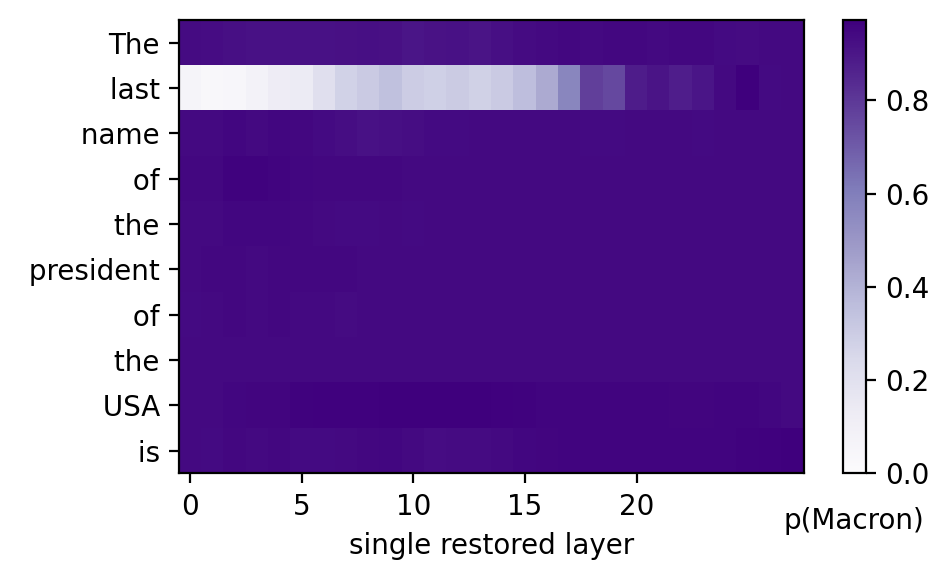

In [16]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
            vmin=0,
        )
ax.invert_yaxis()
ax.set_yticks([0.5 + i for i in range(len(differences))])
ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
ax.set_yticklabels(labels)

ax.set_xlabel(f"single restored layer")
cb = plt.colorbar(h)
cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
plt.tight_layout()
plt.show()

